In [ ]:
%pip install -Uq langchain_community==0.2.12 langgraph==0.2.14 langchain-aws==0.1.17 langchain_core==0.2.35  langsmith python-dotenv

In [ ]:
import dotenv
dotenv.load_dotenv()

In [ ]:
import math
from collections import deque
from typing import Optional,Literal,List,Any
from langchain_core.output_parsers.base import BaseOutputParser
import uuid
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

from pydantic import BaseModel, Field


def swap_roles(messages):
    converted = []
    for message in messages:
        if isinstance(message, AIMessage):
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return  converted



class ReasoningStep(BaseModel):
    """A reasoning step for the solution
    """
    title : str = Field(
        description = """ brief title for the reasoning step."""
    )
    
    content : str = Field(
        description = """ Detailed explanation of the reasoning step."""
    )
        
    next_action : str = Field(
        description = """ "continue" to proceed with more steps or "final_answer" if you are confident in your solution.."""
    )
    @property
    def as_message(self):
        return f"**Title:**\n{self.title}\n\n**Content:**\n{self.content}\n\n**Next_action:**\n{self.next_action}"
    
class InitialCandidates(BaseModel):
    """A reasoning step for the slution
    """
    

class Reflection(BaseModel):
    """The critique and reflections on logic and correctness of previous solution. 
    """
    
    # title : str = Field(description="A brief title for the reasoning step")
    
    content: str = Field(
        description="""Detailed step by step critique and reflections on logic and correctness of previous solution.
        """
    )
        
    score: int = Field(
        description="Score from 0-10 on the quality of the solution. if you are confident this can resolve the task or question, you can give 10",
        gte=0,
        lte=10,
    )
    
    found_solution: bool = Field(
        description="Whether the response has fully solved the question or task."
    )

    @property
    def as_message(self):
        return f"Reflections: {self.content}\n\nScore: {self.score}\n\nFound_solution: {self.found_solution}"

    @property
    def normalized_score(self) -> float:
        return self.score / 10.0

class Node:
    def __init__(
        self,
        messages: list[Any],
        reflection: Reflection,
        parent: Optional["Node"] = None,
    ):
        self.messages = messages
        self.uuid = str(uuid.uuid4())
        self.parent = parent
        self.children = []
        self.value = 0
        self.visits = 0
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False
        if self._is_solved:
            self._mark_tree_as_solved()
        self.backpropagate(reflection.normalized_score)

    def __repr__(self) -> str:
        return (
            f"NodeID:{self.uuid}\nvalue:{self.value}\nvisits:{self.visits}\nchildren:{len(self.children)}\nis_terminal:{self.is_terminal}\n_is_solved:{self._is_solved}"
        )

    @property
    def is_solved(self):
        """If any solutions exist, we can end the search."""
        return self._is_solved

    @property
    def is_terminal(self):
        return not self.children

    @property
    def best_child_score(self):
        """Return the child with the highest value."""
        if not self.children:
            return None
        return max(self.children, key=lambda child: int(child.is_solved) * child.value)

    @property
    def height(self) -> int:
        """Check for how far we've rolled out the tree."""
        if self.children:
            return 1 + max([child.height for child in self.children])
        return 1

    def upper_confidence_bound(self, exploration_weight=1.0):
        """Return the UCT score. This helps balance exploration vs. exploitation of a branch."""
        if self.parent is None:
            raise ValueError("Cannot obtain UCT from root node")
        if self.visits == 0:
            return self.value
        # Encourages exploitation of high-value trajectories
        average_reward = self.value / self.visits
        # Encourages exploration of less-visited trajectories
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)
        return average_reward + exploration_weight * exploration_term

    def backpropagate(self, reward: float):
        """Update the score of this node and its parents."""
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            node = node.parent

    def get_messages(self, include_reflections: bool = True):
        # print(self.messages)
        if include_reflections:
            return self.messages + [self.reflection.as_message]
        return self.messages

    def get_trajectory(self, include_reflections: bool = False) -> list[BaseMessage]:
        """Get messages representing this search branch."""
        messages = []
        node = self
        while node:
            messages.extend(
                node.get_messages(include_reflections=include_reflections)[::-1]
            )
            node = node.parent
        # Reverse the final back-tracked trajectory to return in the correct order
        return messages[::-1]  # root solution, reflection, child 1, ...

    def _get_all_children(self):
        all_nodes = []
        nodes = deque()
        nodes.append(self)
        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            for n in node.children:
                nodes.append(n)
        return all_nodes

    def get_best_solution(self):
        """Return the best solution from within the current sub-tree."""
        all_nodes = [self] + self._get_all_children()
        best_node = max(
            all_nodes,
            # We filter out all non-terminal, non-solution trajectories
            key=lambda node: int(node.is_terminal and node.is_solved) * node.value,
        )
        return best_node

    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent

In [ ]:
import re
import json

class TextOutputParser(BaseOutputParser[str]): 
    verbose :bool = Field( default=False)

    def parse(self, text: str) -> str:
        if self.verbose:
            print(text)
        pattern = r"<final_answer>(.*?)</final_answer>"
        match = re.search(pattern, text, re.DOTALL)
        if match:
            text = match.group(1)
            return text.strip()
        else:
            raise json.JSONDecodeError

    @property
    def _type(self) -> str:
        return "TextOutputParser"

    

def extract_jsons(text):
    # Regular expression pattern to match JSON objects enclosed in ```json ```
    pattern = r'```json\s*([\s\S]*?)\s*```'
    
    # Find all matches in the text
    matches = re.findall(pattern, text)
    
    # List to store extracted and parsed JSON objects
    extracted_jsons = []
    
    for match in matches:
        try:
            # Parse the JSON string into a ReasoningStep object
            json_obj = json.loads(match)
            extracted_jsons.append(ReasoningStep.parse_obj(json_obj))
        except json.JSONDecodeError:
            # If parsing fails, add the raw string instead
            extracted_jsons.append(match)
    
    return extracted_jsons

class JsonArrayOutputParser(BaseOutputParser[str]): 
    verbose :bool = Field( default=False)

    def parse(self, text: str) -> str:
        if self.verbose:
            print(text)
        return extract_jsons(text)

    @property
    def _type(self) -> str:
        return "JsonArrayOuputParser"

In [ ]:
from typing_extensions import TypedDict


class TreeState(TypedDict):
    # The full tree
    root: Node
    # The original input
    input: str
    answer: str = ''

In [ ]:
from langchain_aws import ChatBedrock,ChatBedrockConverse
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser,XMLOutputParser,JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder,HumanMessagePromptTemplate

model_id = "anthropic.claude-3-5-sonnet-20240620-v1:0" 
# "mistral.mistral-large-2407-v1:0"

llm = ChatBedrockConverse(
    model=model_id,
    temperature=1,
    max_tokens=4000,
    credentials_profile_name = 'c35'
)

In [ ]:
llm_2 = ChatBedrockConverse(
    model=model_id,
    temperature=0.01,
    max_tokens=4000,
    region_name='us-west-2',
    credentials_profile_name = 'c35'
)
llm_2.invoke("hello")

## Reflection
The reflection chain will score agent outputs based on the decision and the tool responses. We will call this within the other two nodes.

In [ ]:
from langchain_core.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable

reflect_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
You are a critical analyst who reviews solutions and improves upon them with deep reflection.
You will be provided with step-by-step solution to solve user's problem or task, please reflect and grade the solution.

**Reasoning Steps**
<reasoning_steps>
{reasoning_steps}
</reasoning_steps>

**Your Objectives:**
- Critically analyze the previous solution.
- Identify areas for improvement.

**Instruction**
- Only provide your reviews and judgement, don't try to give the answer to the problem/task by yourself.
            
""",
        ),
        ("user", "{input}"),
        # MessagesPlaceholder(variable_name="candidate"),
    ]
)


reflection_llm_chain =(
    reflect_prompt
    | llm_2.with_config(
        run_name="Reflection"
    ).with_structured_output(Reflection)
)

## Initial Response
We start with a single root node, generated by this first step. It responds to the user input either with a tool invocation or a response.

In [ ]:
from langchain_core.prompt_values import ChatPromptValue
from langchain_core.runnables import RunnableConfig

init_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an agent, an expert problem solver specializing in providing initial solutions using thorough chain-of-thought reasoning.

**Your Objectives:**
- Understand the problem deeply.
- Generate intital step for next iteration, which it will be consolidated as step-by-step solution.

**Instruction:**
- After each reasoning step, decide whether you need to continue refining your reasoning or if you're ready to pass your reasoning step to the next iteration.
- Use at least {N} different approaches.
- Don't try to solve the problem or task in one time, you can only generate one reasoning step for each approach, and you will generate in next iteration.
- Be explicit about any uncertainties or assumptions in your reasoning.

**Response Format:**
For each step of each approach, provide a title that describes what you're doing in that step, along with the content. 
Respond in JSON format with the following keys:
- "title": A brief title for the reasoning step.
- "content": Detailed explanation of the reasoning step.
- "next_action": "continue" to proceed with more steps or "final_answer" if you are confident in your solution.

**Example Response:**
### approach 1 ###
```json
{{
    "title": "Analyzing the Problem",
    "content": "To solve this problem, I will first...",
    "next_action": "continue"
}}
```
### approach 2 ###
```json
{{
    "title": "Analyzing the Problem",
    "content": "To solve this problem, I will first...",
    "next_action": "continue"
}}
```
 """,
        ),
        ("user", "{input}"),
        # MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


initial_answer_chain = init_prompt_template | llm.with_config(
    run_name="GenerateInitialCandidate"
)|JsonArrayOutputParser()



In [ ]:
# test_input = "How many 'r' in strawberry?"
# initial_candidates = initial_answer_chain.invoke(
#     # {"input": "9.11 and 9.8, which is bigger ?"}
#     {"input":test_input,"N":3 }
# )

In [ ]:
# print(initial_candidates)

In [ ]:

iterate_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an agent, an expert problem solver specializing in providing initial solutions using thorough chain-of-thought reasoning."),
        (
            "user",
"""
Given this user's original request, you might be provided with some existing reasoning steps and reflections from last iteration in following, decide if you need to add another step or if you're ready to give the final answer. 

**User request**
<request>
{input}
</request>

**Existing steps:**
<existing_steps>
{existing_steps}
</existing_steps>

**Reflection: **
<reflection>
{reflection}
</reflection>

**Your Objectives:**
- Understand the problem deeply.
- Provide a detailed next step to move forward.

**Instruction:**
- After each reasoning step, decide whether you need to continue refining your reasoning or if you're ready to pass your reasoning step to the next iteration.
- Use at least three different approaches to validate your answer.
- Don't try to solve the problem or task in one time, you can only generate one reasoning step, and you will generate in next iteration.
- Be explicit about any uncertainties or assumptions in your reasoning.
 """,
        ),
        # MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


iterate_answer_chain = iterate_prompt_template | llm.with_config(
    run_name="IterateCandidate"
).with_structured_output(ReasoningStep)

## Candidate Generation
The following code prompts the same LLM to generate N additional candidates to check

This generates N candidate values


## expand

In [ ]:
# res = iterate_answer_chain.batch([{"input": test_input,"existing_steps":candidate,"reflection": ""} for candidate in initial_candidates])

In [ ]:
# [print(f"*****************iterate_answer_chain****[{i}]********************\n{re.as_message}") for i,re in enumerate(res)]

In [ ]:
# reflections = reflection_llm_chain.batch(
#         [{"input": test_input, "reasoning_steps": str(candidate)} for candidate in initial_candidates]
#     )

In [ ]:
# [print(f"*********************[{i}]********************\n{re.as_message}") for i,re in enumerate(reflections)]

In [ ]:
# iterate_answer = iterate_answer_chain.batch(
#     [{"input": test_input,"existing_steps":candidate,"reflection":reflection.as_message} for candidate,reflection in zip(initial_candidates,reflections)] 
# )
# print(iterate_answer)

## Final Answer Generation

In [ ]:
final_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system","You are an expert problem solver specializing ensures the step by step solution is correct, comprehensive, and well-presented, and give final answer to solve user's problem or task."),
        (
            "user",
"""Given this user's original request:
**User request**
<request>
{input}
</request>
    
**Here are step by step solution:**
<existing_steps>
{existing_steps}
</existing_steps>

**Your Objectives:**
- Address any remaining issues.
- Provide the final polished answer to solve user's problem or task

**Response Format:**
response your final answer in xml tag <final_answer> 

"""
        ),
        # ("user", "{input}"),
        # MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


final_answer_chain = final_prompt_template | llm.with_config(
    run_name="final_answer"
)| TextOutputParser()

## Starting Node¶
We will package up the candidate generation and reflection in a single node of our graph. This is represented by the following function:

In [ ]:
from collections import defaultdict

def select(root: Node) -> dict:
    """Starting from the root node a child node is selected at each tree level until a leaf node is reached."""

    if not root.children:
        return root
    
    node = root
    while node.children:
        max_child = max(node.children, key=lambda child: child.upper_confidence_bound())
        node = max_child

    return node

def expand(state: TreeState, config: RunnableConfig) -> dict:
    """Starting from the "best" node in the tree, generate N candidates for the next step."""
    print("*******expand*********")
    root = state["root"]
    best_candidate: Node = select(root)
    
    best_steps = best_candidate.get_trajectory()
    
    # 如果已经标记成最终答案，则直接返回
    # if best_steps[-1].next_action == 'final_answer':
    #     best_candidate._mark_tree_as_solved()
    #     return state
    
    best_reflection = best_candidate.reflection
    best_steps_str = '\n'.join([step.json(ensure_ascii=False) for step in best_steps])
    print(f"***********select best_candidate reasoning_steps***\n{best_steps_str}")
    print(f"***********with best_candidate's reflection***\n{'score: '+str(best_reflection.score) + ' ;found_solution: '+ str(best_reflection.found_solution)}")
    
    # n条
    n = config['configurable'].get("N",3)
    
    # 基于整个best_steps路径，生成n条后续路径
    new_candidates = iterate_answer_chain.batch([{"input": state['input'],
                                                  "existing_steps":best_steps_str,
                                                  "reflection":best_reflection.json(ensure_ascii=False)}]*n)
    
    # 查看生成的n条候选路径
    # new_candidates_str = '\n'.join([ f"{idx} :{can.as_message}" for idx,can in enumerate(new_candidates)])
    # print(f"***********generate new candiates reasoning_steps***\n{new_candidates_str}")
    
    # 针对整个best_steps + new_candidate路径，生成reflection
    reflections = reflection_llm_chain.batch(
        [{"input": state["input"], 
          "reasoning_steps": best_steps_str+'\n'+cand.json(ensure_ascii=False)} for cand in new_candidates]
    )
    
    # Grow tree
    child_nodes = [
        Node([cand], parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(new_candidates, reflections)
    ]
    best_candidate.children.extend(child_nodes)
    # We have already extended the tree directly, so we just return the state
    return state

In [ ]:
def generate_initial_response(state: TreeState,config: RunnableConfig) -> dict:
    """Generate N candidates from the initial responsee"""
    empty_reflection=Reflection(score=0,content='',title='',found_solution=False)
    
    # 生成初始化的n个候选
    initial_candidates = initial_answer_chain.invoke(
        {"input":state["input"],"N": config['configurable'].get("N",3)}
    )
    initial_candidates_str = '\n'.join([step.json(ensure_ascii=False) for step in initial_candidates])
    # print(f"*****initial_candidates*****:\n{initial_candidates_str}")
    # Reflect on each candidate,
    # initial_candidates返回值是ReasoningStep，如果json失败，则返回str
    reflections = reflection_llm_chain.batch(
        [{"input": state["input"],
          "reasoning_steps": cand.json(ensure_ascii=False) if isinstance(cand,ReasoningStep) else cand} for cand in initial_candidates]
    )
    
    # print(f"*****reflections for initial_candidates*****:\n{[ 'score: '+str(reflection.score) + ' ;found_solution: '+str(reflection.found_solution)  for reflection in reflections]}")
    
    root = Node([], reflection=empty_reflection)
    # Grow tree
    child_nodes = [
        Node([cand], parent=root, reflection=reflection)
        for cand, reflection in zip(initial_candidates, reflections)
    ]    
    
    root.children.extend(child_nodes)
    return {
        **state,
        "root": root,
    }

In [ ]:
def generate_final_answer(state: TreeState):
    root = state["root"]
    
    # 获取整棵树里全局最优路径
    best_candidate: Node = root.get_best_solution()
    best_steps = best_candidate.get_trajectory()
    print("*******final_answer_best_node****")
    print(best_candidate)
    best_reflection = best_candidate.reflection
    best_steps_str = '\n'.join([step.json(ensure_ascii=False) for step in best_steps])
    # print(f"***********generate_final_answer reasoning_steps***\n{best_steps_str}")
    # print(f"***********with generate_final_answer's reflection***\n{'score: '+str(best_reflection.score) + ' ;found_solution: '+ str(best_reflection.found_solution)}")
    
    final_answer_chain = final_prompt_template | llm.with_config(run_name="final_answer")| TextOutputParser()
    
    answer = final_answer_chain.invoke({"input": state["input"],"existing_steps":best_steps_str})
    return {
        **state,
        "answer": answer
    }


## Create Graph
With those two nodes defined, we are ready to define the graph. After each agent step, we have the option of finishing.

In [ ]:
from typing import Literal

from langgraph.graph import END, StateGraph, START


def should_loop(state: TreeState,config: RunnableConfig) -> Literal["expand", "__end__","final_answer"]:
    """Determine whether to continue the tree search."""
    root = state["root"]
    if root.is_solved:
        return "final_answer"
    if root.height > config["configurable"].get("max_height", 3):
        return "final_answer"
    return "expand"


builder = StateGraph(TreeState)
builder.add_node("initial_response", generate_initial_response)
builder.add_node("expand", expand)
builder.add_node("final_answer",generate_final_answer)
builder.add_edge(START, "initial_response")
# builder.add_edge("initial_response", "expand")
builder.add_edge("final_answer", END)


builder.add_conditional_edges(
    "initial_response",
    # Either expand/rollout or finish
    should_loop,
)
builder.add_conditional_edges(
    "expand",
    # Either continue to rollout or finish
    should_loop,
)

graph = builder.compile()

In [ ]:
from IPython.display import Image,Markdown, display,HTML
import time
Image(graph.get_graph().draw_mermaid_png())

## Invoke

In [ ]:
# question = "How many 'r' in strawberry."
question = "列出全部第三个字母是 A 的国家"
# question = "有个六位数11□□11,它能被17和19整除,“□□”里的两位数是___。"

config = {"configurable": {"N": 3,"max_height":5}}
last_step = None

In [ ]:
%%time
for step in graph.stream({"input": question},config):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")

In [ ]:
print(last_step['final_answer']['answer'])

In [ ]:
last_step['final_answer']['root'].children

In [ ]:
solution_node = last_step['final_answer']["root"].get_best_solution()
solution_node

In [ ]:
best_trajectory = solution_node.get_trajectory()
best_trajectory

In [ ]:
solution_node.reflection

### 题目及答案
1. 3
2. \[ x = \frac{1}{3} \quad \text{and} \quad x = -\frac{5}{2} \]
3.  \[ t(n)=\left\{\begin{array}{ll} 16.50n + 72.75 & \text{if } 0 \leq n < 50 \\ 11.75n + 35 & \text{if } n \geq 50 \end{array}\right. \]
4. \frac{3}{4}(4 - 2x^2)^{4/3} + c \]
5. 中间的数字是53
6. 4小时

In [ ]:
cases = [
 "how many 'r' in strawberry",
"""
Solve completely by factoring.
$8 x^{2}+5 x-4=2 x^{2}-8 x+1$  
$x=-\frac{5}{2} ; x=\frac{1}{3}$  
$x=\frac{5}{2} ; x=\frac{1}{3}$  
$x=\frac{5}{2} ; x=-\frac{1}{3}$  
$x=-\frac{5}{2} ; x=-\frac{1}{3}$.  
""",
"""
A restaurant offers a catering service which costs $\$ 16.50$ per person with a $\$ 72.75$ service charge. For parties of 50 or more people, a group discount applies, and the cost is $\$ 11.75$ per person along with the service charge dropping to $\$ 35.00$.

Write a piecewise-defined function which calculates the total cost, $T$, (in dollars) of the catering service, which serves $n$ people.
\[
T(n)=\left\{\begin{array}{ll}
16.50 n+72.75 & \text { if } \square \times \leq n \leq \square \\
11.75 n+35 & \text { if } n \geq 50
\end{array}\right.
\]
""",
"""
Find the indefinite integral. Check your result by differentiating. (Use $C$ for the constant of integration.)
\[
\int \sqrt[3]{4-2 x^{2}}(-4 x) d x
\]
$\square$
Need Help?
Read It
Master It
""",
    
"有个六位数11□□11,它能被17和19整除,“□□”里的两位数是___。",
"甲、乙两地相距150千米,两辆汽车同时从甲地开往乙地,第一辆车速度为40千米/时,第二辆车速度为35千米/时,第一辆车到达乙地后立刻返回甲地,途中与第二辆车相遇。求从出发到相遇经过了多长时间。",
   
]

## 测试高考题

In [19]:
import pandas as pd

In [20]:
df = pd.read_excel("2024高考数学.xlsx")

In [21]:
df.head(5)

,sn,type,question,answer
0,1,单项选择题，请在4个候选答案中选择一个正确答案,"已知集合A={x|-5<x³<5}, B={-3,-1,0,1,2,3}, 则A∩B= ( ...",A
1,2,单项选择题，请在4个候选答案中选择一个正确答案,"若 z²/(z-1) = 1+i, 则z= ( )\nA.-1-i \nB.-1+i...",C
2,3,单项选择题，请在4个候选答案中选择一个正确答案,"已知向量a=(1,0), b=(2, x), 若b⊥(b-4a), 则x= ( )\nA.-...",D
3,4,单项选择题，请在4个候选答案中选择一个正确答案,"已知cos(α+β)=m, tanα·tanβ=2, 则cos(α-β)= ( )\nA.-...",A
4,5,单项选择题，请在4个候选答案中选择一个正确答案,"5. 已知圆柱和圆锥的底面半径相等，侧面积相等，且它们的高均为√3, 则圆锥的体积为( )\...",B


In [22]:
prompt_template = """
{type}
{question}
"""

## Test1 并行生成候选集采用蒙特卡洛树搜索

In [ ]:
config = {"configurable": {"N": 5,"max_height":4}}
for i,query in enumerate(cases):
    display(Markdown(f"**question**: {query}"))
    last_step = None
    t1 = time.time()
    for step in graph.stream({"input": query},):
        last_step = step
        step_name, step_state = next(iter(step.items()))
        print(step_name)
        print("rolled out: ", step_state["root"].height)
        print("---")
    display(Markdown(f"**time cost**: {(time.time()-t1):.1f} s"))
    
    #get final result


    display(Markdown(f"**response**:"))
    display(Markdown(last_step['final_answer']['answer']))
    
    solution_node = last_step['final_answer']["root"].get_best_solution()
    best_trajectory = solution_node.get_trajectory(include_reflections=True)
    # display(Markdown(f"**best_trajectory**:"))
    # display(Markdown(best_trajectory[-1].content))
    display(Markdown("***************"*30))

## Test 2. step by step 解题


In [ ]:
config = {"configurable": {"N": 3,"max_height":3}}
for i,query in enumerate(cases):
    display(Markdown(f"**question**: {query}"))
    last_step = None
    t1 = time.time()
    initial_response = initial_answer_chain.invoke(
                {"input": query})
    display(Markdown(f"**time cost**: {(time.time()-t1):.1f} s"))
    display(Markdown(f"**response**:"))
    display(Markdown(initial_response.content))
    display(Markdown("-----------"*10))

## Test 3 直接解题

In [ ]:


simple_template = ChatPromptTemplate.from_messages(
    [
        ("user", "{input}"),
    ]
)
simple_chain = simple_template | llm 

for i,query in enumerate(cases):
    display(Markdown(f"**question**: {query}"))
    last_step = None
    t1 = time.time()
    initial_response = simple_chain.invoke(
                {"input": query})
    display(Markdown(f"**time cost**: {(time.time()-t1):.1f} s"))
    display(Markdown(f"**response**:"))
    display(Markdown(initial_response.content))
    display(Markdown("-----------"*10))

## Qwen2.5-math-72B-instruct 测试截图
1. 正确
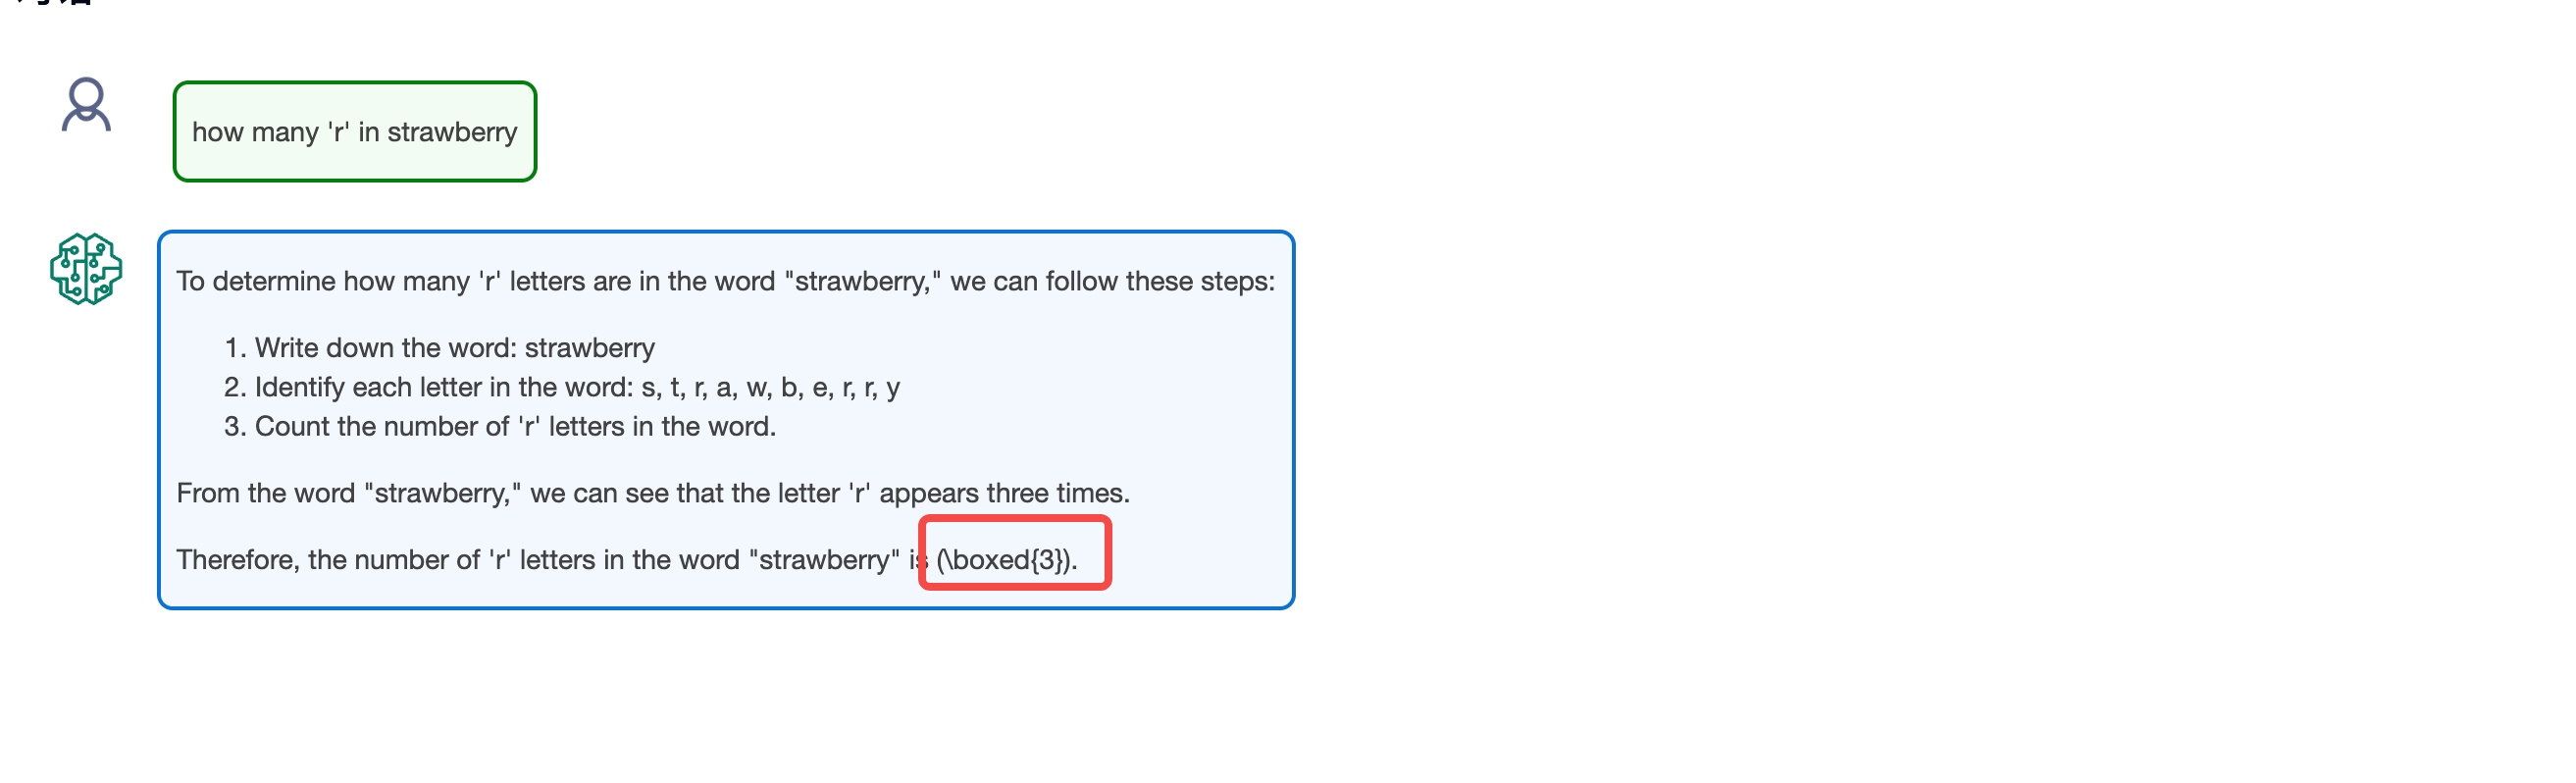
2. 正确
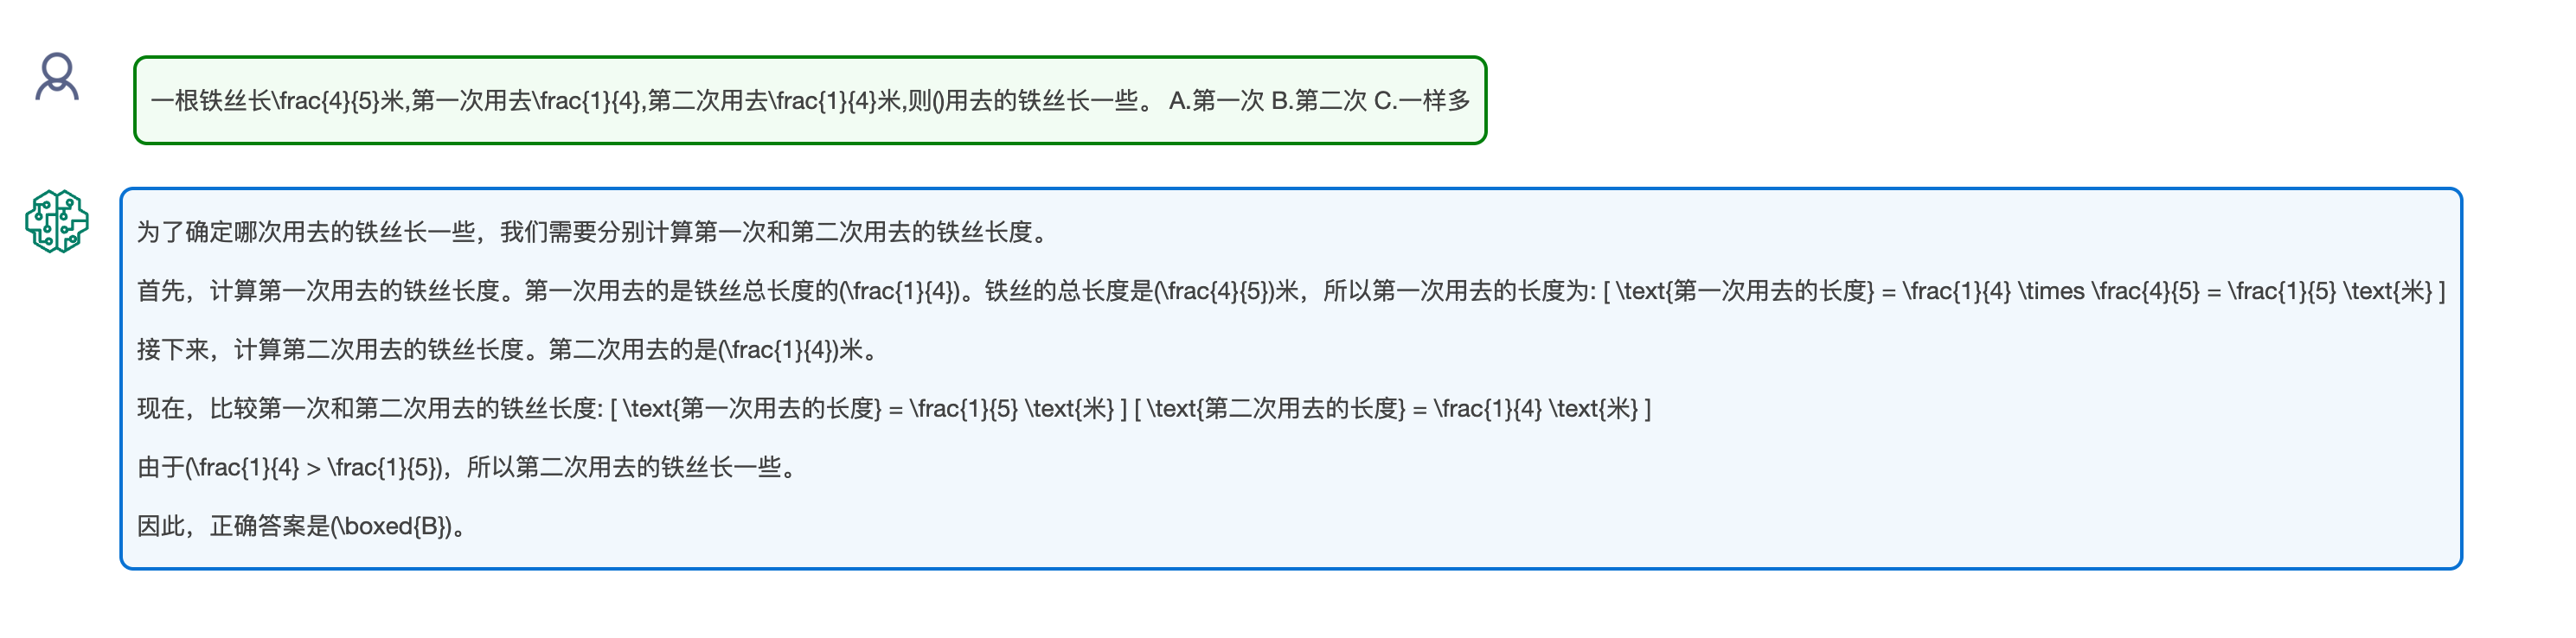


3. 正确
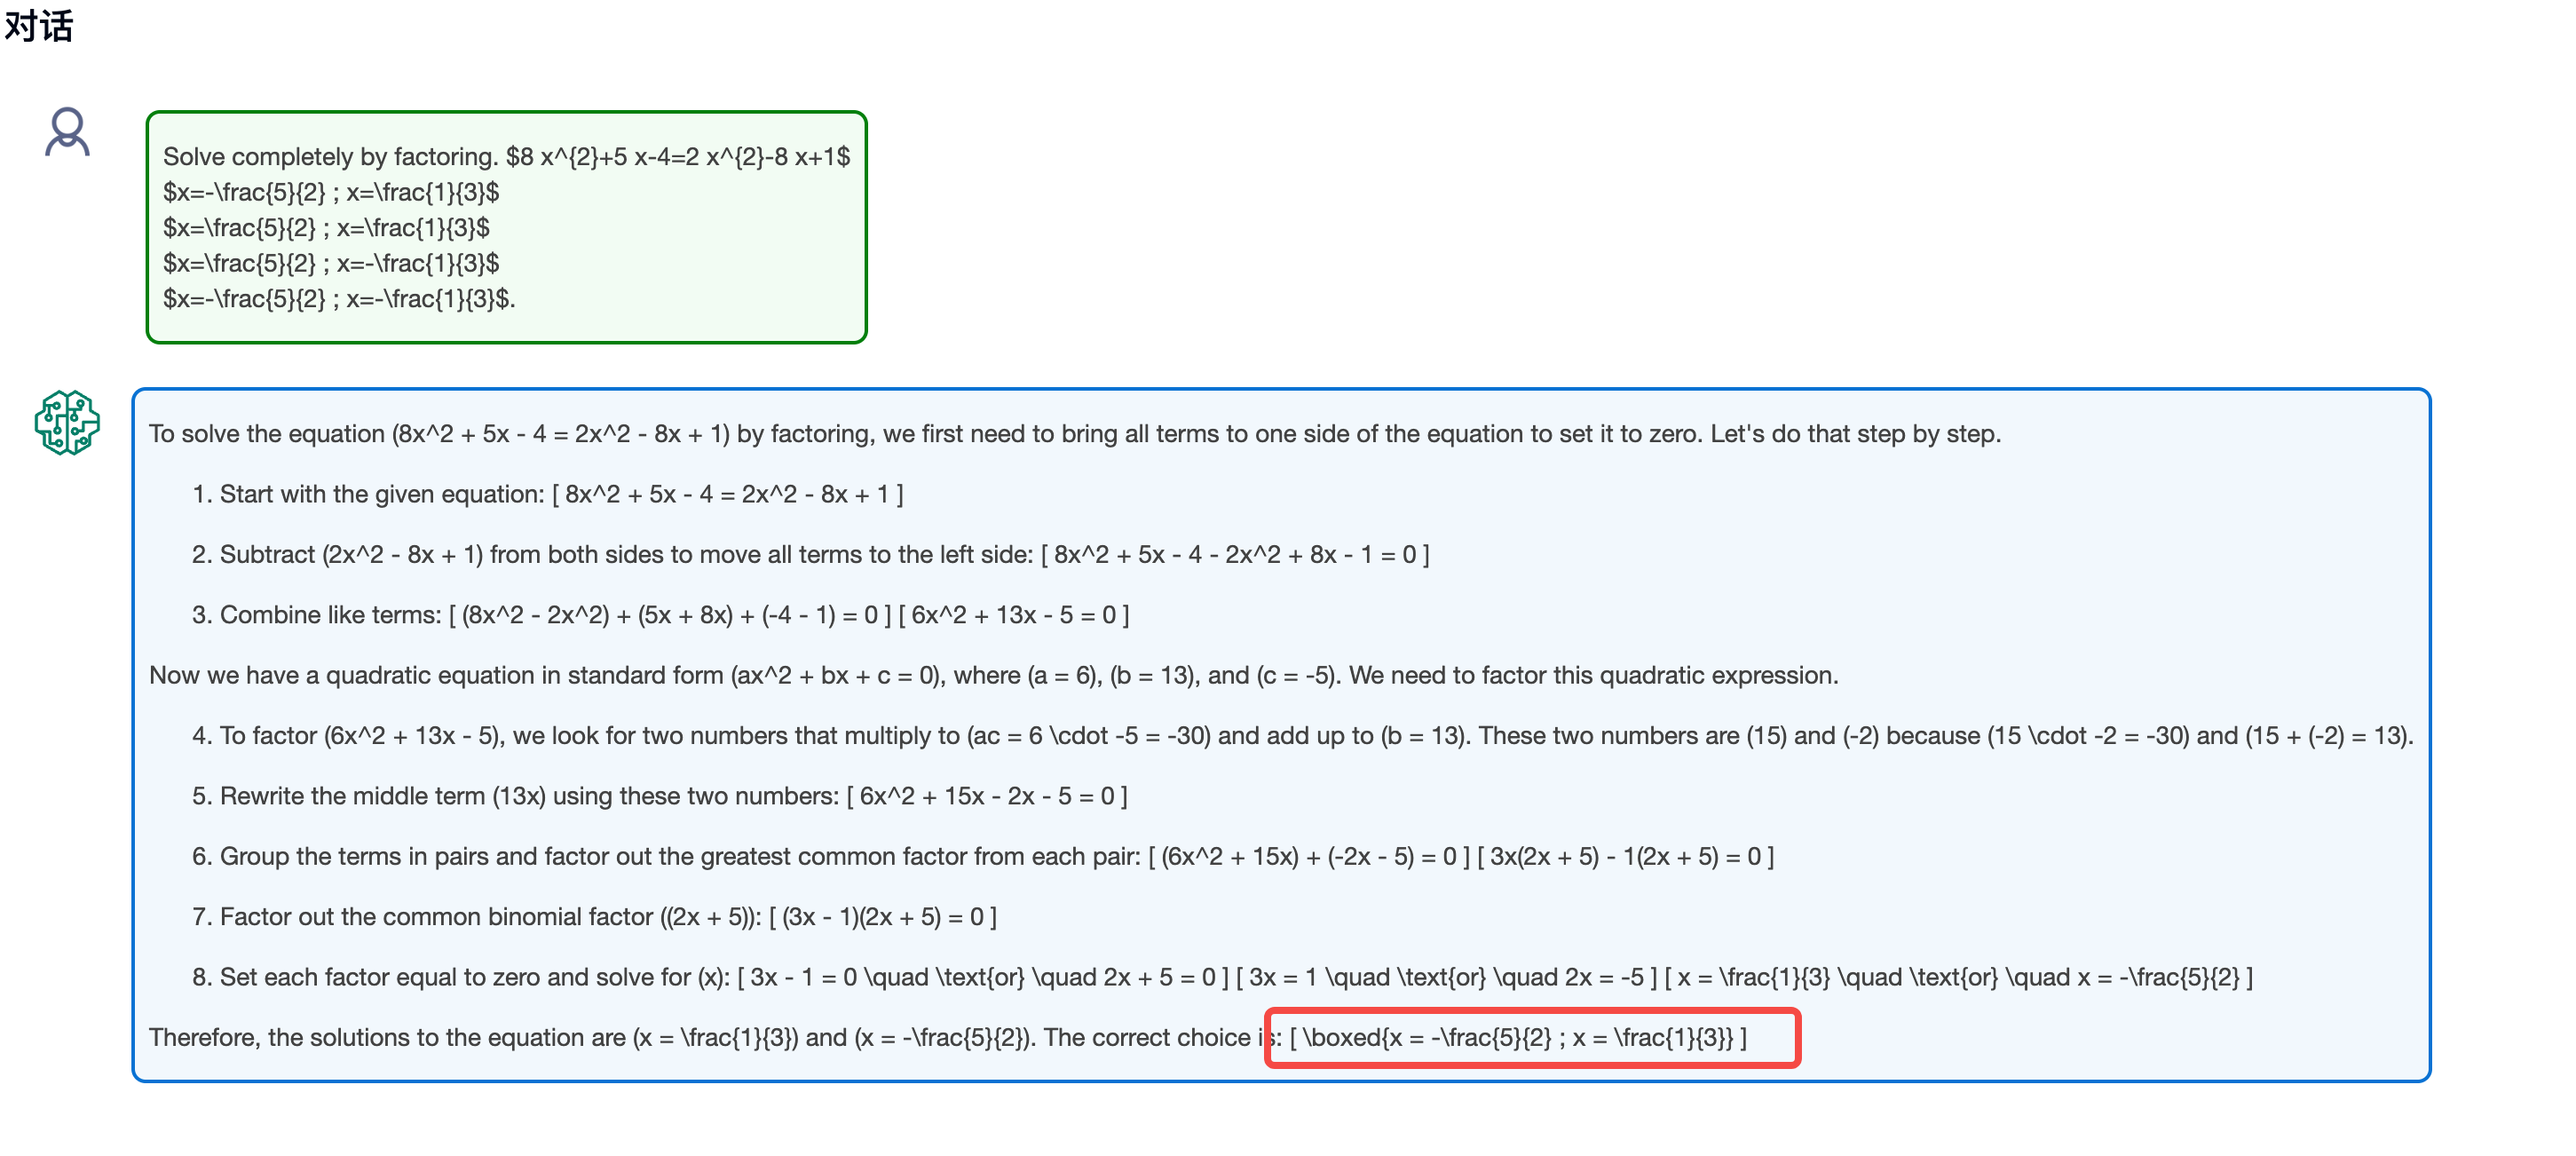

4. 正确
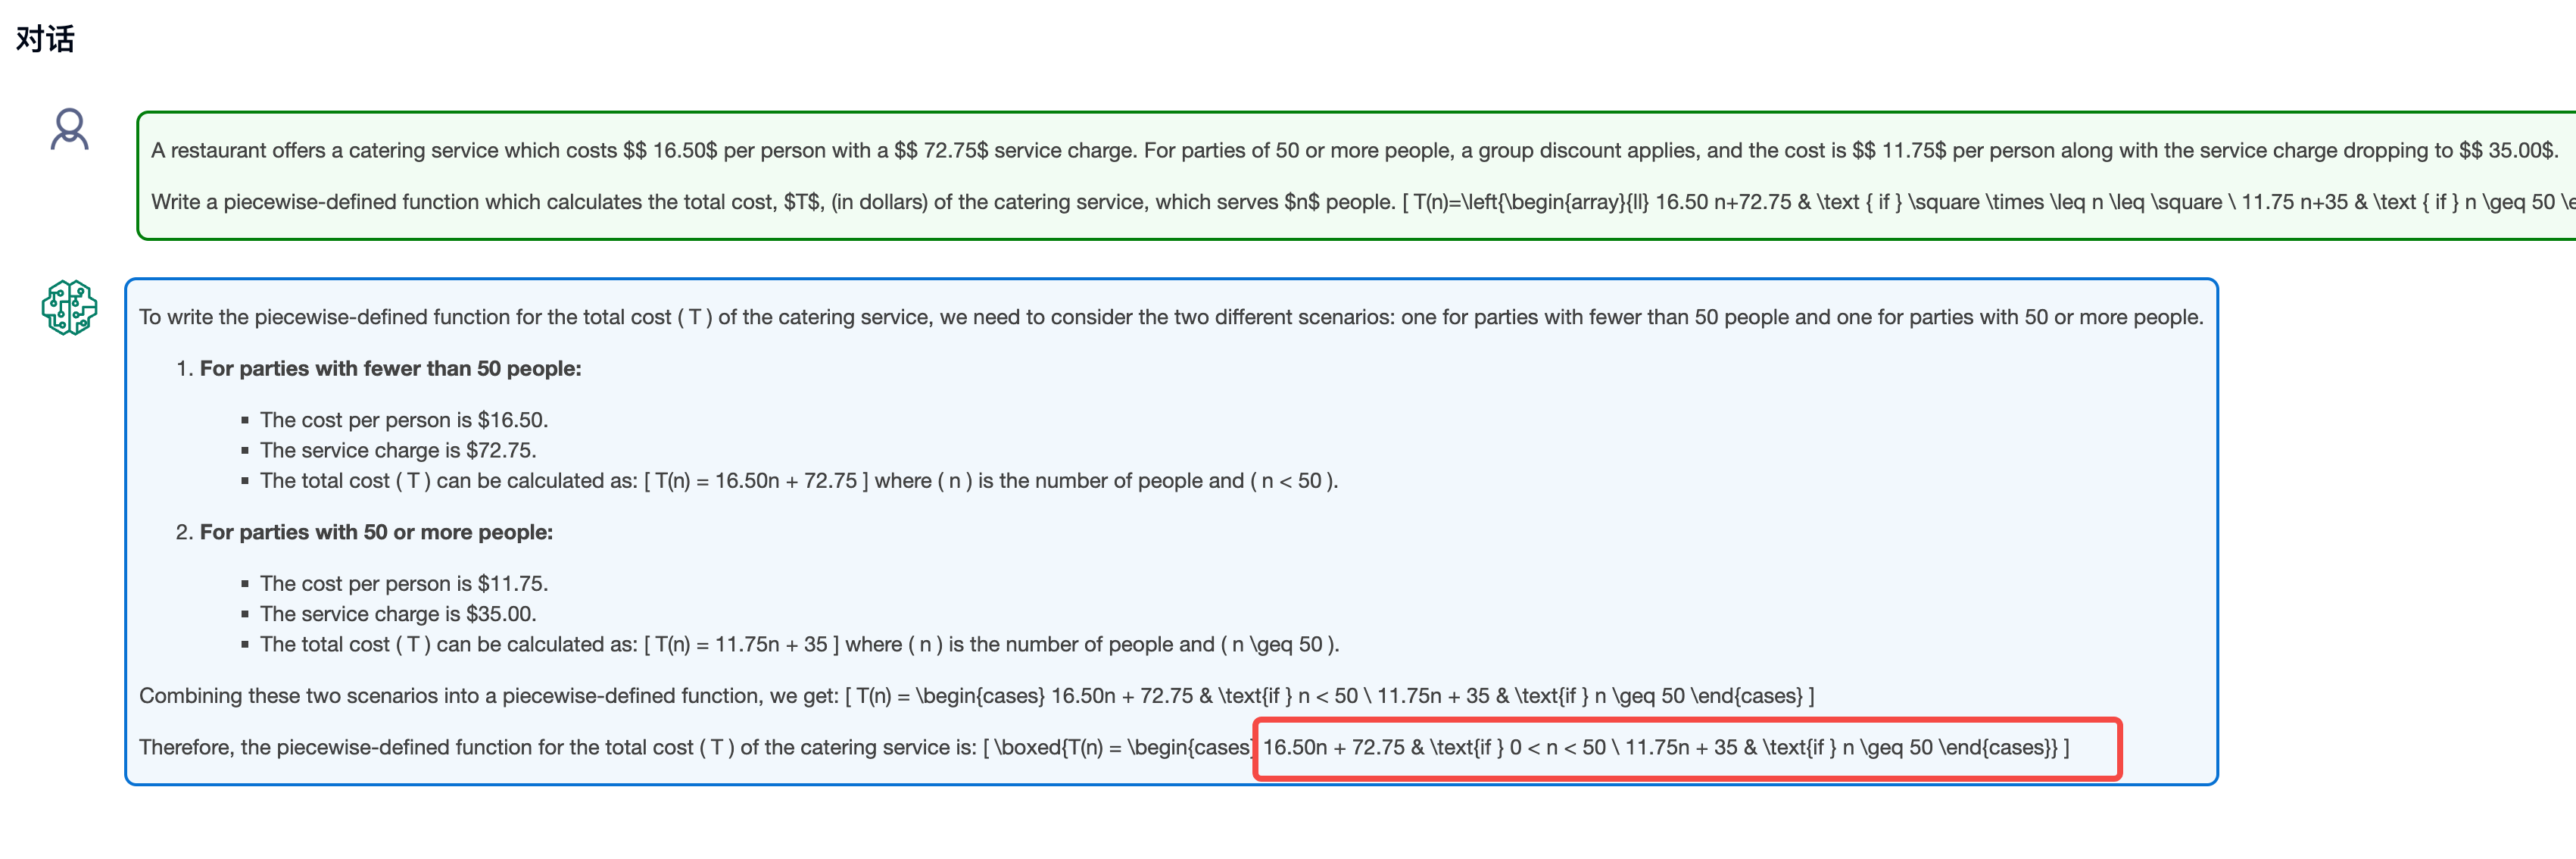

5. 正确
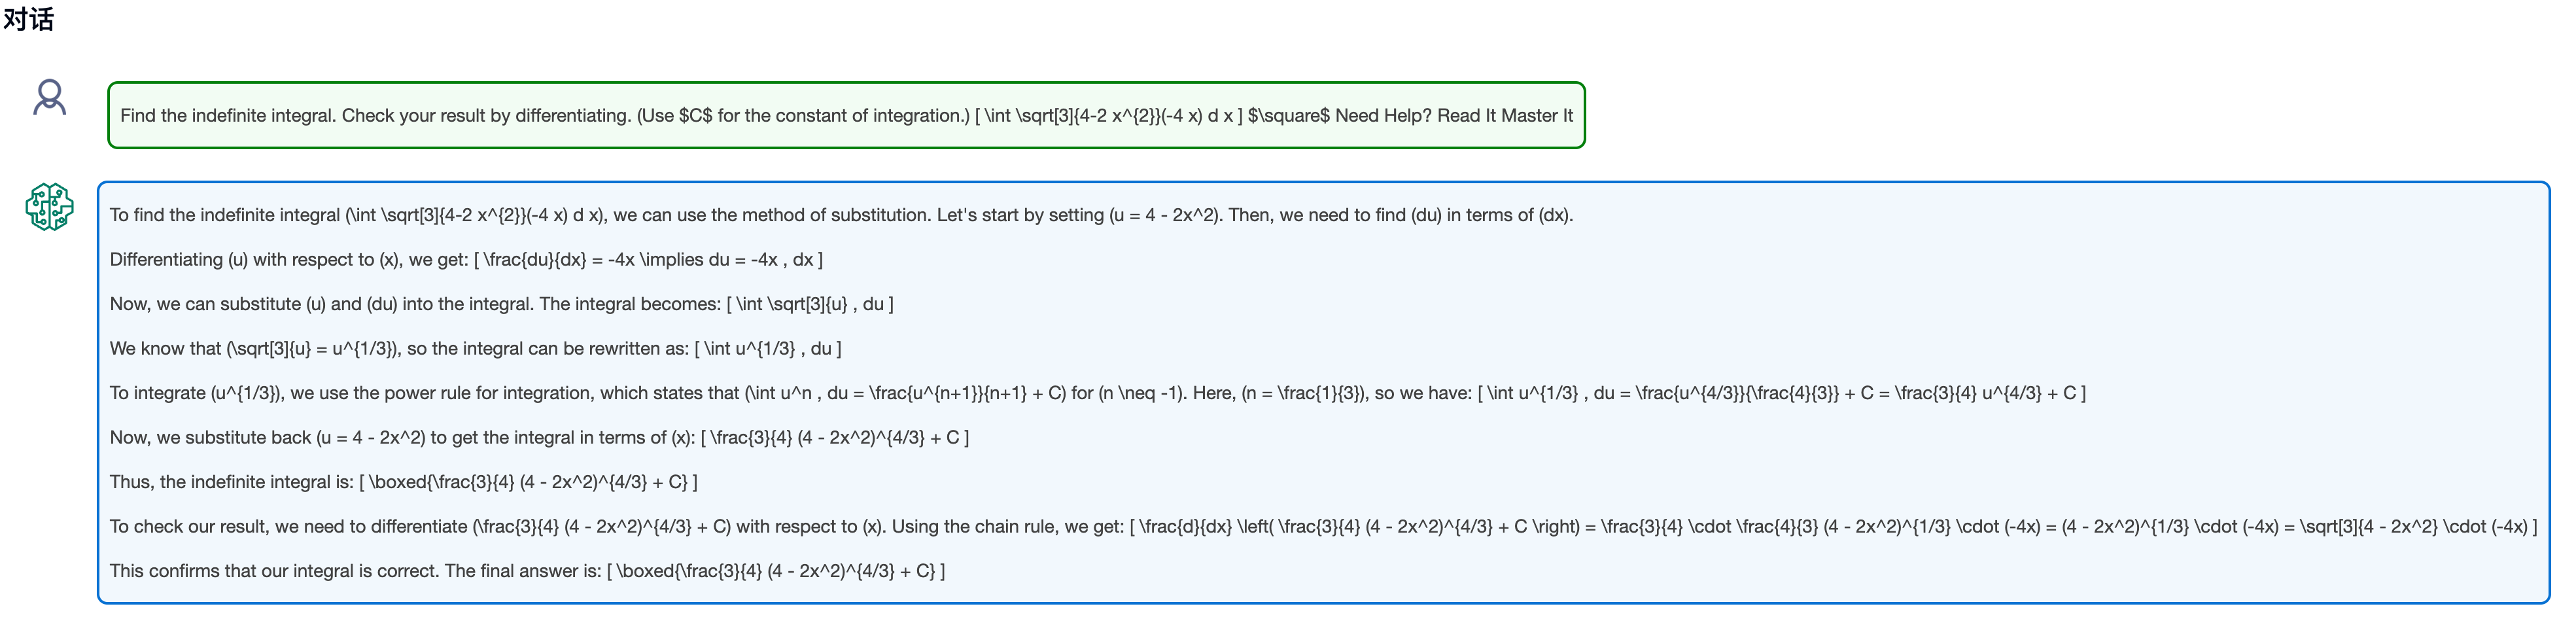

6. 错误， 超出最大长度
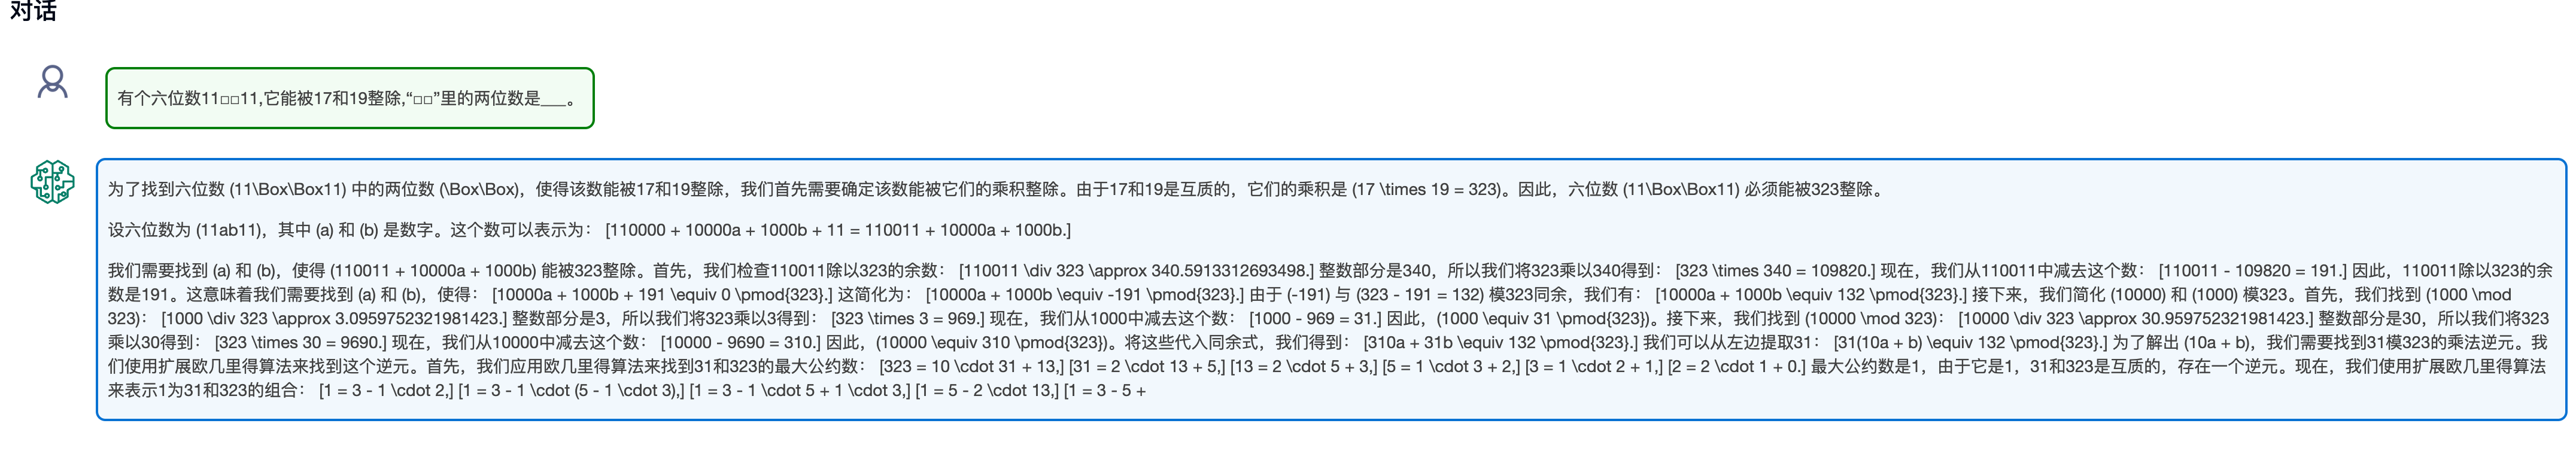

7. 正确
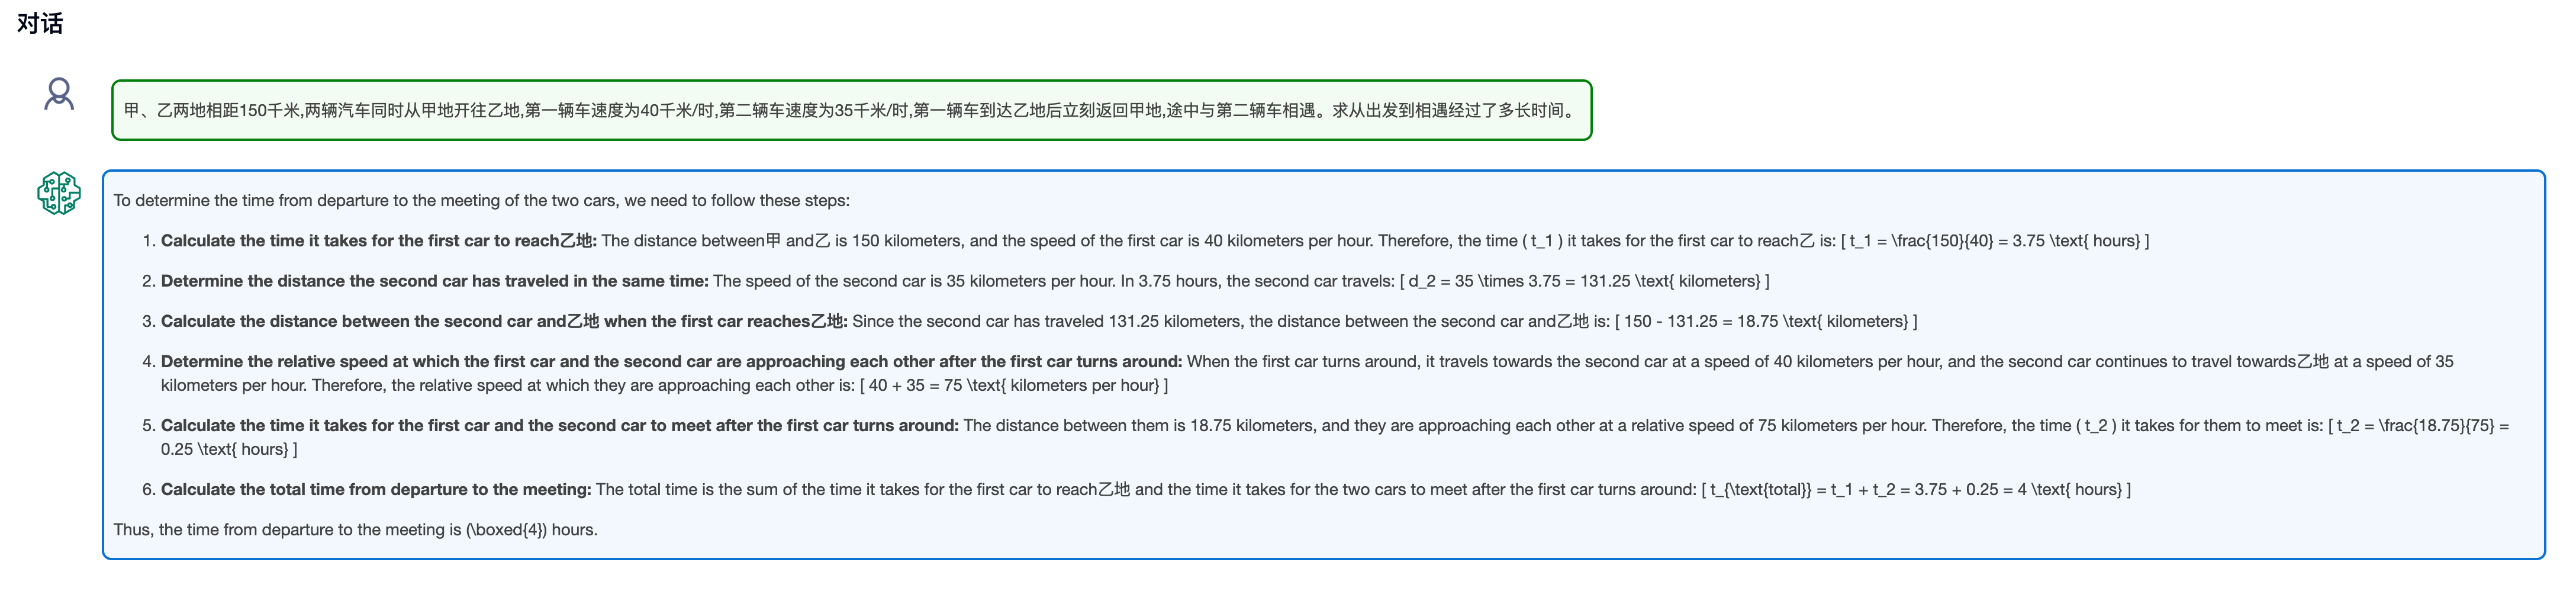